In [89]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import johnsonsu


In [90]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [91]:
print("Training data has", train.shape[0], "instances, and", train.shape[1], "features")
print("Testing data has", test.shape[0], "instances, and", test.shape[1], "features")

Training data has 1460 instances, and 81 features
Testing data has 1459 instances, and 80 features


### Exploring Target Variable = SalePrice

In [92]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [93]:
def plot_distributions(column):
    fig, axes = plt.subplots(1, 6, figsize=(30, 6), sharey=True)

    distributions = {
        'Normal': stats.norm,
        'Johnson SU': stats.johnsonsu,
        'Log-Normal': stats.lognorm,
        'Exponential': stats.expon,
        'Gamma': stats.gamma,
        'Weibull': stats.weibull_min
    }

    x = np.linspace(min(column), max(column), 100)
    for ax, (name, distribution) in zip(axes, distributions.items()):
        params = distribution.fit(column)
        p = distribution.pdf(x, *params)
        sns.histplot(column, kde=False, color='blue', stat='density', bins=30, ax=ax)
        ax.plot(x, p, 'k', linewidth=2, label=name)
        ax.legend()
        ax.set_title(f'{name} Distribution')

    plt.tight_layout()
    plt.show()


In [94]:
def best_fit_distribution(column):
    distributions = {
        'Normal': stats.norm,
        'Johnson SU': stats.johnsonsu,
        'Log-Normal': stats.lognorm,
        'Exponential': stats.expon,
        'Gamma': stats.gamma,
        'Weibull': stats.weibull_min
    }

    best_fit = None
    best_log_likelihood = -np.inf

    for name, distribution in distributions.items():
        params = distribution.fit(column)
        log_likelihood = np.sum(distribution.logpdf(column, *params))

        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_fit = name

    return best_fit



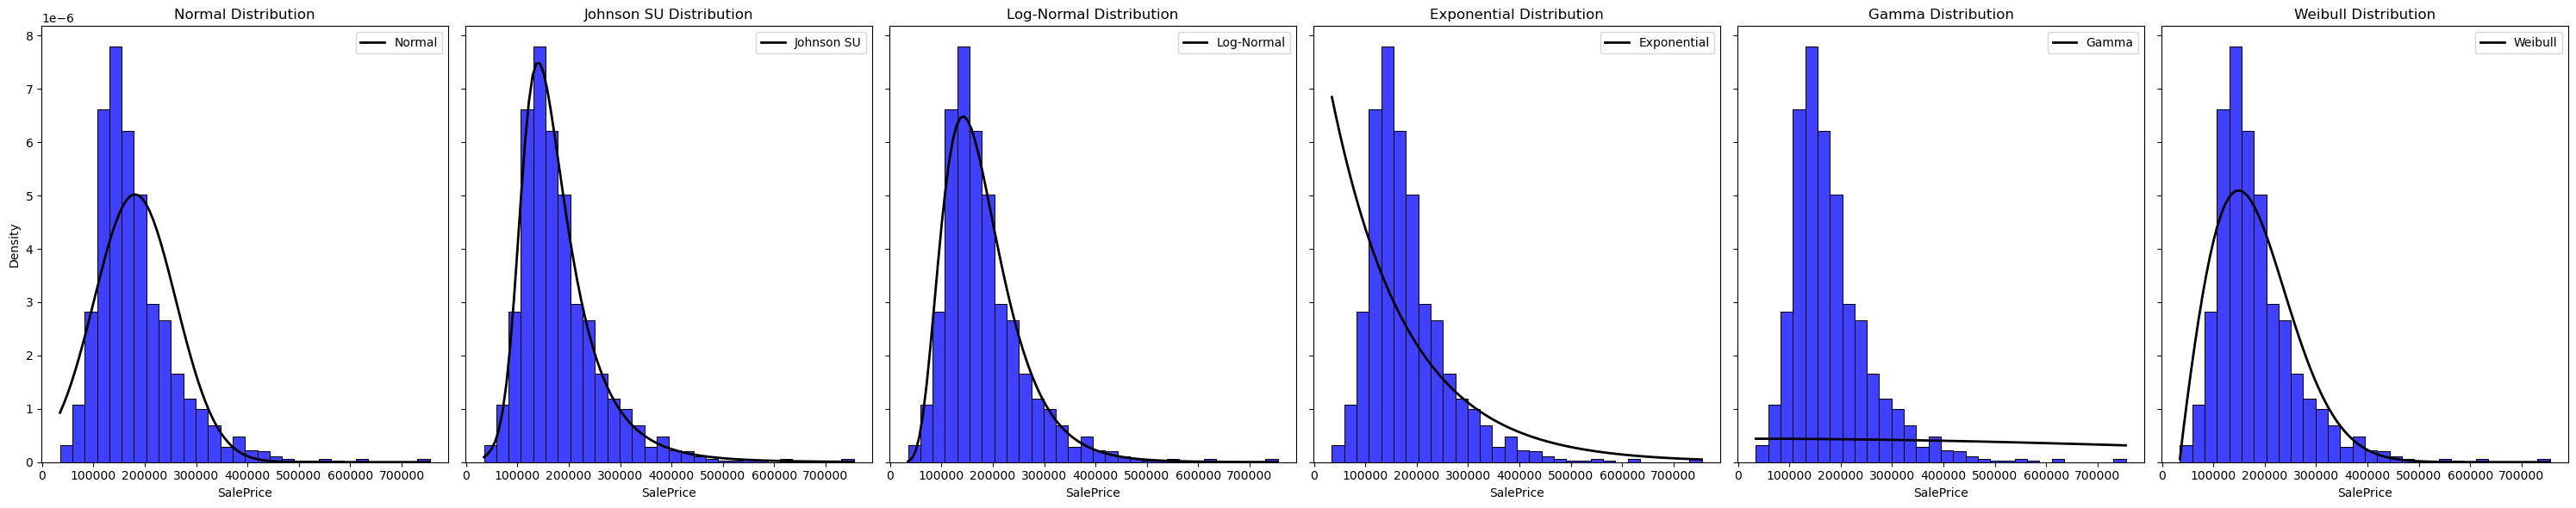

The best fitting distribution is: Johnson SU


In [95]:
plot_distributions(train['SalePrice'])
best_fit = best_fit_distribution(train['SalePrice'])
print(f'The best fitting distribution is: {best_fit}')


Johnson SU distribution is the best fit for the SalePrice distribution. It is not normally distributed and will have to be transformed before we train the model and make predictions.

In [96]:
gamma, delta, xi, lam = johnsonsu.fit(train['SalePrice'])
transformed_data = gamma + delta * np.arcsinh((train['SalePrice'] - xi) / lam)

# Add transformed and standardized data to the DataFrame for comparison
y = transformed_data


In [97]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(transformed_data)
normal = normal.apply(test_normality)
print(not normal.any())


True


In [98]:
# train_ID = train['Id']
# test_ID = test['Id']

# train.drop(['Id'], axis=1, inplace=True)
# test.drop(['Id'], axis=1, inplace=True)

train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# train_features['source'] = 'train'
# test_features['source'] = 'test'

df = pd.concat([train_features, test_features]).reset_index(drop=True)


Before checking if the the quantitive variables are normally distibuted or will have to be transformed, we will handle the missing values.  

### Handling missing values

Text(0.5, 1.0, 'Percent missing data by feature')

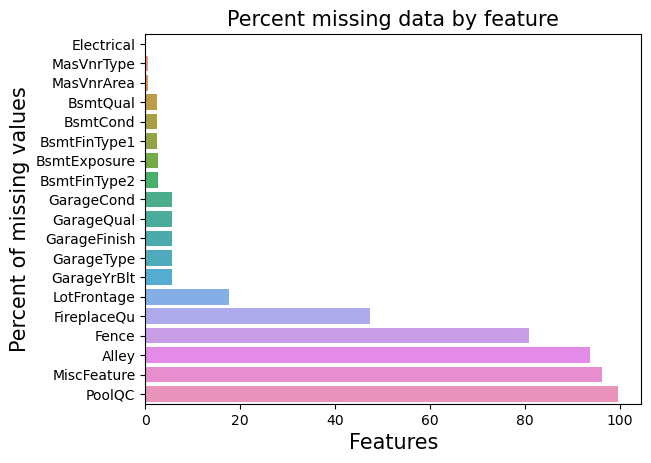

In [99]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots()
sns.barplot(x=missing.values / len(train) * 100, y=missing.index)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


In [100]:
# For PoolQC, MiscFeature, Alley, Fence, and FireplaceQu missing values means None exist, hence we can impute it with "None"


